# Imports:

In [31]:
import anndata as ad
import pandas as pd
import numpy as np
import torch
import os
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import umap
import random
from transformers import T5ForConditionalGeneration, T5Tokenizer, TrainingArguments, Trainer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
os.environ["OMP_NUM_THREADS"] = "1"

# Load Data:


## Myeloid:

In [4]:
mye_data = ad.read_h5ad('../data/mye/mye_query_adata.h5ad')
mye_data

AnnData object with n_obs × n_vars = 3430 × 3000
    obs: 'cell_type', 'cancer_type', 'batch'
    uns: 'cancer_type_colors', 'cell_type_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
# mye_train = ad.read_h5ad('data/mye/mye_reference_adata.h5ad')
# mye_train

# all_mye = ad.concat([mye_test, mye_train], axis=0)
# Data shaped: (Cells, Genes)
# print(mye_train.X.shape)
print(mye_data.X.shape)
# print(all_mye.X.shape)

(3430, 3000)


In [6]:
# Labelled cancer types within data:
mye_data.obs.cancer_type.values.unique()

['MYE', 'OV-FTC', 'ESCA']
Categories (3, object): ['ESCA', 'MYE', 'OV-FTC']

In [7]:
mye_data.obs.cell_type.values.unique()

['Mono_CD14', 'Mono_CD16', 'Macro_SPP1', 'cDC2_CD1C', 'Macro_C1QC', ..., 'Macro_NLRP3', 'cDC3_LAMP3', 'Macro_INHBA', 'cDC1_CLEC9A', 'pDC_LILRA4']
Length: 11
Categories (11, object): ['Macro_C1QC', 'Macro_INHBA', 'Macro_LYVE1', 'Macro_NLRP3', ..., 'cDC1_CLEC9A', 'cDC2_CD1C', 'cDC3_LAMP3', 'pDC_LILRA4']

In [8]:
# Gene names:
mye_genes = np.array(mye_data.var.index)
mye_genes[0:5]

array(['HES4', 'ISG15', 'AGRN', 'TNFRSF18', 'TNFRSF4'], dtype=object)

In [9]:
len(mye_genes)

3000

In [11]:
# Saving gene names for myeloid dataset:
np.savetxt('../data/mye/mye_genes.txt', mye_genes, delimiter=',', fmt='%s')

# Generate Cell Embeddings:

In [12]:
def get_seq_embed(X, gene_names, prompt_prefix="", trunc_index = None):
    # Return number of genes in data:
    n_genes = X.shape[1]

    # Check trunc_index is an integer and <no.genes in data:
    if trunc_index is not None and not isinstance(trunc_index, int):
        raise Exception('trunc_index must be None or an integer!')
    elif isinstance(trunc_index, int) and trunc_index>=n_genes:
        raise Exception('trunc_index must be smaller than the number of genes in the dataset')

    get_test_array = []
    for cell in (X):
        # Where the cell value for a gene == 0:
        zero_indices = (np.where(cell==0)[0])
        # Sorts the cell values from  largest to smallest (retruns indices):
        gene_indices = np.argsort(cell)[::-1]
        # Remove any genes in the sorted index where the cell value ==0:
        filtered_genes = gene_indices[~np.isin(gene_indices, list(zero_indices))]
        # Subset the genes, limiting it to trunc_index:
        if trunc_index is not None:
            get_test_array.append(np.array(gene_names[filtered_genes])[0:trunc_index]) 
        else:
            get_test_array.append(np.array(gene_names[filtered_genes])) 
    # Appends a prompt prefer to the test array data:
    get_test_array_seq = [prompt_prefix+' '.join(x) for x in get_test_array]
    return(get_test_array_seq)

In [13]:
N_TRUNC_GENE = 1000
sample_cells_data = get_seq_embed(mye_data.X, mye_genes, 
        prompt_prefix = "", trunc_index=N_TRUNC_GENE)

In [50]:
sample_cells_data[0][0:25]

'S100A9 S100A8 FTL LYZ TMS'

# UMAP Viz:

In [14]:
# PCA dimension reduction to 50 dimensions
pca = PCA(n_components=50)
pca_result = pca.fit_transform(mye_data.X)

In [15]:
# Compute UMAP on the PCA-reduced data
embedding_sanity_check = umap.UMAP(min_dist=0.5, spread=1
                                  ).fit_transform(pca_result)

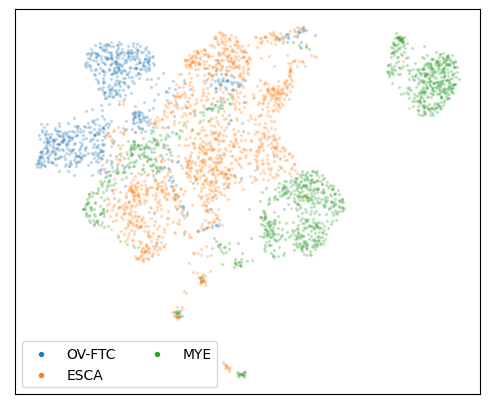

In [20]:
plt.rcParams['axes.facecolor']='white'
plt.figure(figsize=(6,5)) 
random.seed(23)
np.random.seed(2023)
all_labels = np.unique(mye_data.obs.cancer_type)
random.shuffle(all_labels)
colors = sns.color_palette('tab10', len(all_labels))
for i, label_name in enumerate(all_labels):
    plt.scatter(embedding_sanity_check[mye_data.obs.cancer_type==label_name, 0], 
                        embedding_sanity_check[mye_data.obs.cancer_type==label_name, 1], s= 2,
                        label=label_name,color=colors[i],alpha=0.2)
leg = plt.legend(prop={'size': 10},loc='lower left',ncol=2)
plt.rcParams["legend.markerscale"] = 2.0
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xticks([])
plt.yticks([])
plt.show()

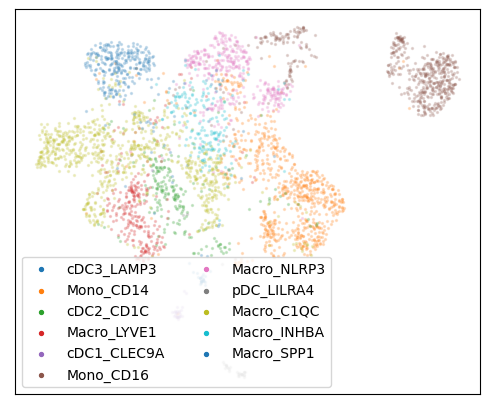

In [37]:
plt.rcParams['axes.facecolor']='white'
plt.figure(figsize=(6,5)) 
random.seed(23)
np.random.seed(2023)
all_labels = np.unique(mye_data.obs.cell_type)
random.shuffle(all_labels)
colors = sns.color_palette('tab10', len(all_labels))
for i, label_name in enumerate(all_labels):
    plt.scatter(embedding_sanity_check[mye_data.obs.cell_type==label_name, 0], 
                        embedding_sanity_check[mye_data.obs.cell_type==label_name, 1], s= 2,
                        label=label_name,color=colors[i],alpha=0.2)
leg = plt.legend(prop={'size': 10},loc='lower left',ncol=2)
plt.rcParams["legend.markerscale"] = 2.0
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xticks([])
plt.yticks([])
plt.show()

# Correlate Estimated Clusters to Cancer Types:

In [32]:
# define k-means clustering:
kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=3, random_state=42, 
                                         batch_size=20, n_init='auto')
kmeans.fit(mye_data.X)

C:\Users\Will\anaconda3\envs\moa\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(batch_size=20, n_clusters=3, n_init='auto', random_state=42)

In [34]:
annotation_label = mye_data.obs.cancer_type
# Getting cluster centers and labels
labels = kmeans.labels_
print('aRI', sklearn.metrics.adjusted_rand_score(labels, annotation_label))
print('aMI', sklearn.metrics.adjusted_mutual_info_score(labels, annotation_label))

aRI 0.26514391502512613
aMI 0.28609421800109236


## Correlate to Cell Type:

In [35]:
# define k-means clustering:
kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=11, random_state=42, 
                                         batch_size=20, n_init='auto')
kmeans.fit(mye_data.X)

C:\Users\Will\anaconda3\envs\moa\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(batch_size=20, n_clusters=11, n_init='auto', random_state=42)

In [36]:
annotation_label = mye_data.obs.cell_type
# Getting cluster centers and labels
labels = kmeans.labels_
print('aRI', sklearn.metrics.adjusted_rand_score(labels, annotation_label))
print('aMI', sklearn.metrics.adjusted_mutual_info_score(labels, annotation_label))

aRI 0.3108574492890381
aMI 0.373285694965238
